In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('/content/drive/MyDrive/ECBT/intents.json').read()
intents = json.loads(data_file)

In [3]:
'''Here we iterate through the patterns and tokenize the sentence using nltk.word_tokenize() function 
and append each word in the words list. We also create a list of classes for our tags.'''

import nltk
nltk.download('punkt')

for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
nltk.download('wordnet')
# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


105 documents
22 classes ['cancel', 'confirm', 'delay', 'delivery', 'goodbye', 'greeting', 'items', 'mobile app', 'more', 'order status', 'payments', 'personal', 'profile info', 'reasons', 'refund', 'refund status', 'return', 'thanks', 'track', 'use voucher', 'user response', 'withdraw refunds']
145 unique lemmatized words ["'m", "'s", '.', 'a', 'about', 'accept', 'account', 'address', 'agent', 'am', 'an', 'any', 'anyone', 'app', 'are', 'available', 'be', 'become', 'but', 'buy', 'bye', 'call', 'can', 'cancel', 'cancelled', 'card', 'cash', 'change', 'common', 'completed', 'confirmation', 'confirmed', 'contact', 'credit', 'credited', 'customer', 'day', 'deducted', 'delay', 'delayed', 'delete', 'delivered', 'delivery', 'did', 'do', 'doe', 'doing', 'download', 'even', 'for', 'from', 'fund', 'get', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helpline', 'hey', 'hi', 'how', 'i', 'im', 'information', 'is', 'it', 'item', 'kind', 'know', 'later', 'long', 'lot', 'mastercard', 'me', 'm

In [5]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


<ipython-input-5-14f4db91aa1f>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [6]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

print("model created")

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


21/21 [==============================] - 1s 3ms/step - loss: 3.1366 - accuracy: 0.0286 
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 3.0386 - accuracy: 0.1048
Epoch 3/200
21/21 [==============================] - 0s 4ms/step - loss: 2.9639 - accuracy: 0.2190
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 2.8183 - accuracy: 0.2190
Epoch 5/200
21/21 [==============================] - 0s 2ms/step - loss: 2.7570 - accuracy: 0.2286
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 2.6252 - accuracy: 0.2571
Epoch 7/200
21/21 [==============================] - 0s 5ms/step - loss: 2.3767 - accuracy: 0.3238
Epoch 8/200
21/21 [==============================] - 0s 4ms/step - loss: 2.2684 - accuracy: 0.4095
Epoch 9/200
21/21 [==============================] - 0s 7ms/step - loss: 2.1744 - accuracy: 0.3333
Epoch 10/200
21/21 [==============================] - 0s 2ms/step - loss: 1.8767 - accuracy: 0.4762
Epoch 11/200
21/21 [

In [7]:
from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('/content/drive/MyDrive/ECBT/intents.json').read())
words = pickle.load(open('/content/drive/MyDrive/ECBT/words.pkl','rb'))
classes = pickle.load(open('/content/drive/MyDrive/ECBT/classes.pkl','rb'))

In [8]:
def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

In [9]:
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [10]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

In [11]:
def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

In [12]:
#GUI interface for external use
# import tkinter as tk

# BG_GRAY = "#ABB2B9"
# BG_COLOR = "#c5f0e3"
# TEXT_COLOR = "#000000"

# FONT = "Helvetica 14"
# FONT_BOLD = "Helvetica 13 bold"


# def send(event=None):
#     msg = EntryBox.get("1.0", 'end-1c').strip()
#     EntryBox.delete("0.0", tk.END)
#     if msg != '':
#         ChatLog.config(state=tk.NORMAL)
#         ChatLog.insert(tk.END, "You: " + msg + '\n\n')
#         ChatLog.config(foreground="#000000", font=("Verdana", 12))

#         res = chatbot_response(msg)
#         ChatLog.insert(tk.END, "Bot: " + res + '\n\n')

#         ChatLog.config(state=tk.DISABLED)
#         ChatLog.yview(tk.END)


# def chatbot_response(message):
#     # Implement your chatbot logic here
#     return "Chatbot response"


# # Create the main window
# root = tk.Tk()
# root.title("E-Commerce Chatbot")
# root.resizable(width=False, height=False)
# root.configure(width=800, height=800, bg=BG_COLOR)

# # Create Chat window
# ChatLog = tk.Text(root, bd=0, bg=BG_COLOR, fg=TEXT_COLOR, font=FONT_BOLD)
# ChatLog.config(state=tk.DISABLED)

# head_label = tk.Label(root, bg=BG_COLOR, fg=TEXT_COLOR, text="Welcome to E-Commerce Chatbot", font=FONT_BOLD, pady=10)
# head_label.pack()

# line = tk.Label(root, width=450, bg=BG_GRAY)

# # Bind scrollbar to Chat window
# scrollbar = tk.Scrollbar(root, command=ChatLog.yview, cursor="heart")
# ChatLog['yscrollcommand'] = scrollbar.set
# ChatLog.focus()

# # Create Button to send message
# SendButton = tk.Button(root, font=("Verdana", 12, 'bold'), text="Send", width="12", height=15,
#                        bd=0, bg="#ed9061", activebackground="#3c9d9b", fg='#ffffff',
#                        command=send)

# # Create the box to enter message
# EntryBox = tk.Text(root, bg="white", width="29", height="5", font="Arial", background="#dddddd")
# EntryBox.focus()
# EntryBox.bind("<Return>", send)

# # Place all components on the screen
# scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
# line.pack(fill=tk.X, pady=5)
# ChatLog.pack(fill=tk.BOTH, padx=5, pady=5)
# EntryBox.pack(pady=5)
# SendButton.pack(pady=5)

# # Start the Tkinter event loop
# root.mainloop()

In [13]:
def bow(sentence, words, show_details=True):
    # Tokenize input sentence
    sentence_words = clean_up_sentence(sentence)
    # Bag of words initialization
    bag = [0] * len(words)
    
    # Create bag of words representation
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
                if show_details:
                    print("found in bag: %s" % w)
    
    return np.array(bag)

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the necessary data and model
intents = json.loads(open('/content/drive/MyDrive/ECBT/intents.json').read())
words = pickle.load(open('/content/drive/MyDrive/ECBT/words.pkl','rb'))
classes = pickle.load(open('/content/drive/MyDrive/ECBT/classes.pkl','rb'))
model = load_model('/content/drive/MyDrive/ECBT/chatbot_model.h5')

# Function to preprocess input and make predictions
def preprocess_and_predict(sentence):
    sentence_words = clean_up_sentence(sentence)
    return predict_class(' '.join(sentence_words), model)

# Evaluate performance metrics
y_true = []
y_pred = []
for intent in intents['intents']:
    tag = intent['tag']
    for example in intent['patterns']:
        y_true.append(tag)
        preds = preprocess_and_predict(example)
        if preds:
            y_pred.append(preds[0]['intent'])
        else:
            y_pred.append('None')

1/1 [==============================] - 0s 21ms/step


In [15]:
# Classification Report
print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

          cancel       1.00      1.00      1.00         4
         confirm       1.00      1.00      1.00         4
           delay       0.75      0.75      0.75         4
        delivery       0.80      0.80      0.80         5
         goodbye       1.00      1.00      1.00         3
        greeting       1.00      1.00      1.00         5
           items       1.00      1.00      1.00         5
      mobile app       1.00      1.00      1.00         3
            more       1.00      1.00      1.00        11
    order status       1.00      1.00      1.00         3
        payments       1.00      1.00      1.00         6
        personal       1.00      1.00      1.00         3
    profile info       1.00      1.00      1.00         7
         reasons       1.00      1.00      1.00         4
          refund       1.00      1.00      1.00         8
   refund status       1.00      1.00      1.00         5
          ret

4/4 [==============================] - 0s 2ms/step


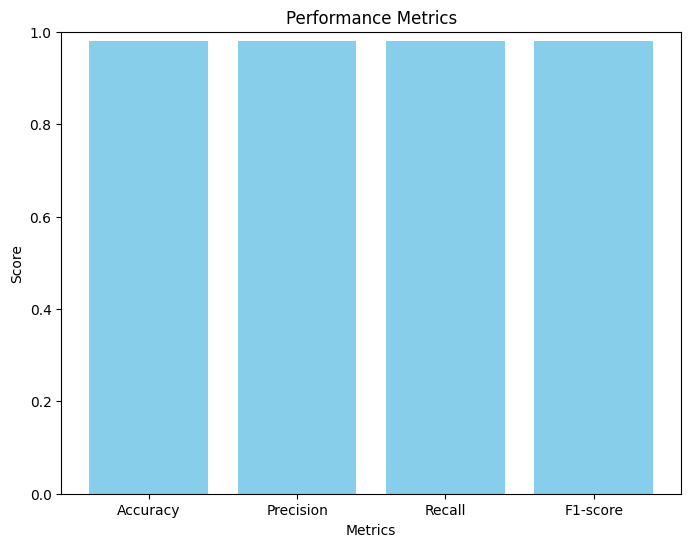

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate predictions
y_pred = model.predict(np.array(train_x))
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to original class labels
y_true = np.argmax(train_y, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Define the performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Plot the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim([0, 1])  # Set the y-axis limit to range between 0 and 1
plt.show()